In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:11<00:00, 14213745.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


50000
torch.Size([3, 32, 32]) 6
torch.Size([3, 32, 32])


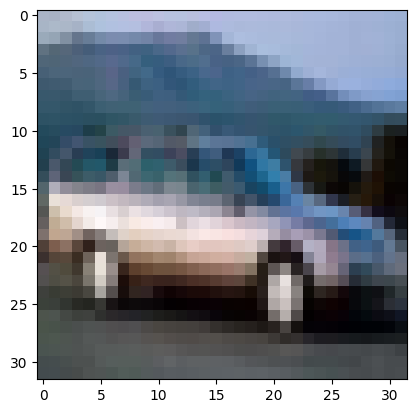

In [4]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
print(trainset[1][0].shape)

plt.imshow(trainset[4][0].permute(1, 2, 0))

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [14]:
from torch import nn

class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

class sig_Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

class dropout_Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    self.m = nn.Dropout(p=0.1)
    self.act = nn.LeakyReLU()
    

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.m(self.act(self.layer1(x)))
    x = self.m(self.act(self.layer2(x)))
    x = self.act(self.layer3(x))

    return x


In [11]:
from torch.optim import SGD
from torch.optim import Adam
lr = 0.001

## SGD Train

In [12]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()
  return acc/cnt

In [269]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()
sgd_acc = []
model = Model(32 * 32 * 3, 1024).to('mps')
SGD_optimizer = SGD(model.parameters(), lr=lr)
for epoch in range(n_epochs):
  model.train()
  total_loss = 0.
    
  for data in trainloader:
    SGD_optimizer.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss=criterion(preds, labels)
    loss.backward()
    SGD_optimizer.step()
    total_loss += loss.item()

  model.eval()
  sgd_loss = accuracy(model, trainloader)
  sgd_acc.append(sgd_loss)
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 450.94391417503357
Epoch   1 | Loss: 450.2262854576111
Epoch   2 | Loss: 449.3842842578888
Epoch   3 | Loss: 448.33328795433044
Epoch   4 | Loss: 447.34166193008423
Epoch   5 | Loss: 446.3948278427124
Epoch   6 | Loss: 445.4454667568207
Epoch   7 | Loss: 444.47463274002075
Epoch   8 | Loss: 443.47728514671326
Epoch   9 | Loss: 442.4402153491974
Epoch  10 | Loss: 441.17684388160706
Epoch  11 | Loss: 439.78591799736023
Epoch  12 | Loss: 438.45037269592285
Epoch  13 | Loss: 437.028174161911
Epoch  14 | Loss: 435.6576929092407
Epoch  15 | Loss: 434.3037233352661
Epoch  16 | Loss: 432.91885566711426
Epoch  17 | Loss: 431.5440483093262
Epoch  18 | Loss: 430.2354655265808
Epoch  19 | Loss: 428.9395236968994
Epoch  20 | Loss: 427.710401058197
Epoch  21 | Loss: 426.46527123451233
Epoch  22 | Loss: 423.0171368122101
Epoch  23 | Loss: 420.2039806842804
Epoch  24 | Loss: 418.07746267318726
Epoch  25 | Loss: 416.1276466846466
Epoch  26 | Loss: 414.28047370910645
Epoch  27 | Loss: 

In [289]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()
adam_acc = []
adam_test_acc = []
model = Model(32 * 32 * 3, 1024).to('mps')
Adam_optimizer = Adam(model.parameters(), lr=lr)
for epoch in range(n_epochs):
  model.train()
  total_loss = 0.
    
  for data in trainloader:
    Adam_optimizer.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss=criterion(preds, labels)
    loss.backward()
    Adam_optimizer.step()
    total_loss += loss.item()

  model.eval()
  adam_loss = accuracy(model, trainloader)
  adam_test_loss = accuracy(model, testloader)
  adam_acc.append(adam_loss)
  adam_test_acc.append(adam_test_loss)

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 432.37672102451324
Epoch   1 | Loss: 344.205771446228
Epoch   2 | Loss: 316.78154265880585
Epoch   3 | Loss: 302.2333290576935
Epoch   4 | Loss: 292.6517388820648
Epoch   5 | Loss: 284.28676879405975
Epoch   6 | Loss: 278.0552451610565
Epoch   7 | Loss: 271.29785108566284
Epoch   8 | Loss: 264.7438108921051
Epoch   9 | Loss: 258.49699878692627
Epoch  10 | Loss: 253.319398522377
Epoch  11 | Loss: 249.32457172870636
Epoch  12 | Loss: 244.09508347511292
Epoch  13 | Loss: 238.62214732170105
Epoch  14 | Loss: 234.42700278759003
Epoch  15 | Loss: 229.34073412418365
Epoch  16 | Loss: 223.52306747436523
Epoch  17 | Loss: 219.31884229183197
Epoch  18 | Loss: 215.68197864294052
Epoch  19 | Loss: 209.18366104364395
Epoch  20 | Loss: 204.69600039720535
Epoch  21 | Loss: 198.98360991477966
Epoch  22 | Loss: 194.9204386472702
Epoch  23 | Loss: 190.18938207626343
Epoch  24 | Loss: 183.8560637831688
Epoch  25 | Loss: 181.6059204339981
Epoch  26 | Loss: 176.4906520843506
Epoch  27 | L

In [17]:
import numpy as np
import matplotlib.pyplot as plt
def plot_acc(train_accs, test_accs, label1, label2):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()


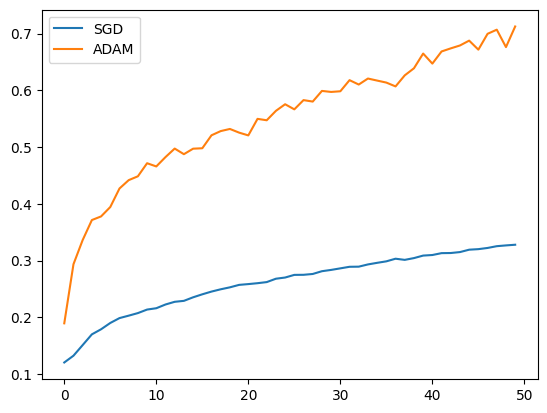

In [272]:
plot_acc(sgd_acc, adam_acc, "SGD", "ADAM")

In [283]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()
sig_acc = []
model = sig_Model(32 * 32 * 3, 1024).to('mps')
Adam_optimizer = Adam(model.parameters(), lr=lr)
for epoch in range(n_epochs):
  model.train()
  total_loss = 0.
    
  for data in trainloader:
    Adam_optimizer.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss=criterion(preds, labels)
    loss.backward()
    Adam_optimizer.step()
    total_loss += loss.item()

  model.eval()
  sig_loss = accuracy(model, trainloader)
  sig_acc.append(sig_loss)
  
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 413.93372869491577
Epoch   1 | Loss: 395.58033978939056
Epoch   2 | Loss: 388.2659111022949
Epoch   3 | Loss: 384.4196888208389
Epoch   4 | Loss: 381.8907368183136
Epoch   5 | Loss: 380.0124179124832
Epoch   6 | Loss: 378.626420378685
Epoch   7 | Loss: 376.85352969169617
Epoch   8 | Loss: 375.69295144081116
Epoch   9 | Loss: 374.3230490684509
Epoch  10 | Loss: 372.37854969501495
Epoch  11 | Loss: 371.614306807518
Epoch  12 | Loss: 370.9043619632721
Epoch  13 | Loss: 369.97166907787323
Epoch  14 | Loss: 368.88791584968567
Epoch  15 | Loss: 367.9624629020691
Epoch  16 | Loss: 366.8065752983093
Epoch  17 | Loss: 366.20015048980713
Epoch  18 | Loss: 366.2418931722641
Epoch  19 | Loss: 365.743528008461
Epoch  20 | Loss: 364.3928816318512
Epoch  21 | Loss: 364.5672240257263
Epoch  22 | Loss: 363.4538758993149
Epoch  23 | Loss: 362.6864846944809
Epoch  24 | Loss: 362.0974301099777
Epoch  25 | Loss: 361.7759187221527
Epoch  26 | Loss: 361.60866689682007
Epoch  27 | Loss: 360.

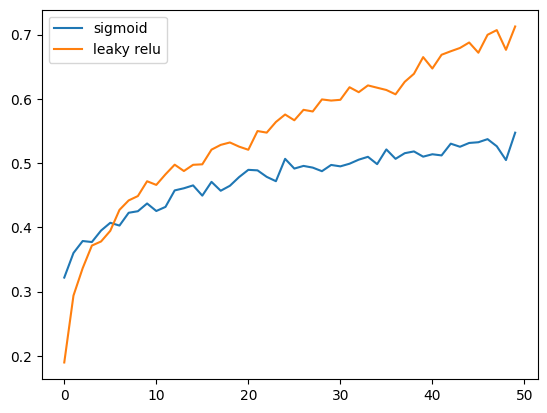

In [284]:
plot_acc(sig_acc, adam_acc, "sigmoid", "leaky relu")

In [15]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()
dropout_train_acc = []
dropout_test_acc = []
model = dropout_Model(32 * 32 * 3, 1024).to('mps')
Adam_optimizer = Adam(model.parameters(), lr=lr)
for epoch in range(n_epochs):
  model.train()
  total_loss = 0.
    
  for data in trainloader:
    Adam_optimizer.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss=criterion(preds, labels)
    loss.backward()
    Adam_optimizer.step()
    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
  
    dropout_train_loss = accuracy(model, trainloader)
    dropout_test_loss = accuracy(model, testloader)
    dropout_train_acc.append(dropout_train_loss)
    dropout_test_acc.append(dropout_test_loss)
  
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 447.83151745796204
Epoch   1 | Loss: 389.16661989688873
Epoch   2 | Loss: 338.054123044014
Epoch   3 | Loss: 321.05231380462646
Epoch   4 | Loss: 309.1237550973892
Epoch   5 | Loss: 302.60973930358887
Epoch   6 | Loss: 294.422834277153
Epoch   7 | Loss: 289.6235282421112
Epoch   8 | Loss: 285.92108178138733
Epoch   9 | Loss: 280.90117359161377
Epoch  10 | Loss: 277.8204584121704
Epoch  11 | Loss: 272.5152008533478
Epoch  12 | Loss: 270.2826682329178
Epoch  13 | Loss: 266.81690418720245
Epoch  14 | Loss: 262.74351465702057
Epoch  15 | Loss: 259.4062490463257
Epoch  16 | Loss: 255.98672997951508
Epoch  17 | Loss: 254.33185815811157
Epoch  18 | Loss: 250.67571663856506
Epoch  19 | Loss: 248.44726049900055
Epoch  20 | Loss: 245.58079540729523
Epoch  21 | Loss: 245.06740045547485
Epoch  22 | Loss: 240.79505014419556
Epoch  23 | Loss: 239.60995471477509
Epoch  24 | Loss: 235.69146347045898
Epoch  25 | Loss: 234.80109828710556
Epoch  26 | Loss: 230.95861095190048
Epoch  27 |

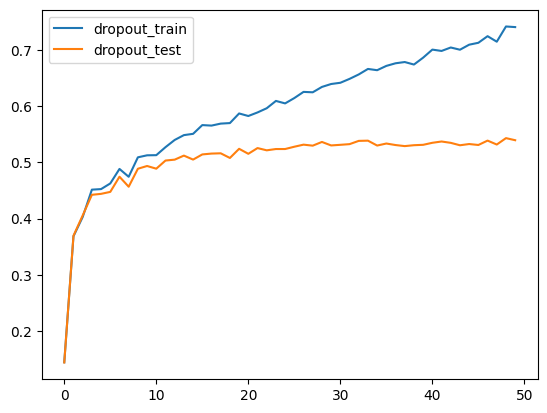

In [18]:
plot_acc(dropout_train_acc, dropout_test_acc, "dropout_train", "dropout_test")